In [37]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [38]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm
from tifffile import imsave
import torchvision.transforms as T
from PIL import Image
import nibabel as nib

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    Resized
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 1.4.dev2418
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 629f558991fcbb7d84d8d9dfd768ee099b3ed24c
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.0.post2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.39.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/la

In [39]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp7jh120jq


In [40]:
import pickle
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [5]:
with open('/kaggle/input/lung-cancer-pkl-file/Lung cancer segmentation dataset with Lung-RADS class/lung_cancer_train.pkl', 'rb') as f:
    t_data = pd.read_pickle(f)


In [6]:
with open('/kaggle/input/lung-cancer-pkl-file/Lung cancer segmentation dataset with Lung-RADS class/lung_cancer_test.pkl', 'rb') as f:
    v_data = pd.read_pickle(f)


In [7]:
t_data

,label1,mask,hu_array,hu_array_old
0,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
1,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
2,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
3,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
4,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
...,...,...,...,...
703,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1015.0, -1024.0, -972.0, -975.0, -1013.0, -..."
704,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1022.0, -1024.0, -957.0, -987.0, -1022.0, -..."
705,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -951.0, -998.0, -1019.0, -..."
706,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1009.0, -968.0, -1022.0, -1007.0, ..."


In [8]:
v_data

,label1,mask,hu_array,hu_array_old
0,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
1,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
2,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
3,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
4,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
...,...,...,...,...
259,LR3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,..."
260,LR3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,..."
261,LR3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,..."
262,LR3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,..."


In [61]:
t_data["hu_array"][0].max()

815.0

In [62]:
t_data["hu_array"][0].min()

-1024.0

In [9]:
def NormalizerHu(matrix): #Normalize our data image

    matrix = (matrix - matrix.min())/(matrix.max()- matrix.min())

    return matrix



In [10]:
norm_t_data = []
for i, j in enumerate(t_data["hu_array_old"]):
  n = NormalizerHu(t_data["hu_array_old"][i])
  norm_t_data.append(n)

norm_t_data = np.array(norm_t_data)

In [11]:
norm_v_data = []
for i, j in enumerate(v_data["hu_array_old"]):
  n = NormalizerHu(v_data["hu_array_old"][i])
  norm_v_data.append(n)

norm_v_data = np.array(norm_v_data)

Since we are going to be using the UNET-R architecture, we will need to split each 3-D image into voxels, by first splitting each image into seperate 16x16 images

Since our input is of LxWxHxC, we must deduce the height(depth) of each image

It seems that our CT scans have variable depths. This means that we need to create an algorithm that can normalize the CT scan images and image segments based on their volumes

In [12]:
t_labels = []
for i in t_data['mask']:
  t_labels.append(i)

t_labels= np.array(t_labels)


In [13]:
v_labels = []
for i in v_data['mask']:
  v_labels.append(i)

v_labels= np.array(v_labels)


In [14]:
import shutil

In [41]:
parent_dir = '/kaggle/working/'
directory = 'NII Training_Images'
t_PATH = os.path.join(parent_dir, directory) 
os.mkdir(t_PATH)

FileExistsError: [Errno 17] File exists: '/kaggle/working/NII Training_Images'

In [42]:
directory = 'NII Valid_Images'
v_PATH = os.path.join(parent_dir, directory) 
os.mkdir(v_PATH)

FileExistsError: [Errno 17] File exists: '/kaggle/working/NII Valid_Images'

In [17]:
t_labels = t_labels.astype(float)
v_labels = v_labels.astype(float)

In [46]:
#shutil.rmtree(v_PATH)
#shutil.rmtree(t_PATH)

In [18]:
k = 0
start = 0
file_pos = 0
train_dict_list = []
init = t_data["label1"][0]
for i,j in enumerate(t_data["label1"]):
  if (init != j):
     f_images = nib.Nifti2Image(norm_t_data[start:k, :, :], affine=np.eye(4))
     f_labels = nib.Nifti2Image(t_labels[start:k, :, :], affine=np.eye(4))
     if(k-start > 6):
      nib.save(f_images, os.path.join(t_PATH, 'train_image' + str(file_pos)+ '.nii.gz'))
      nib.save(f_labels, os.path.join(t_PATH, 'train_label' + str(file_pos)+ '.nii.gz'))
      file_pos = file_pos + 1
     init = j
     start = k
  else:
    k = k + 1

In [19]:
k = 0
start = 0
file_pos = 0
valid_dict_list = []
init = v_data["label1"][0]
for i,j in enumerate(v_data["label1"]):
  if (init != j ):
     f_images = nib.Nifti2Image(norm_v_data[start:k, :, :], affine=np.eye(4))
     f_labels = nib.Nifti2Image(v_labels[start:k, :, :], affine=np.eye(4))
     if(k-start > 6):
      nib.save(f_images, os.path.join(v_PATH, 'valid_image' + str(file_pos)+ '.nii.gz'))
      nib.save(f_labels, os.path.join(v_PATH, 'valid_label' + str(file_pos)+ '.nii.gz'))
      file_pos = file_pos + 1
     init = j
     start = k
  else:
    k = k + 1

In [43]:
os.listdir(v_PATH)

['valid_image0.nii.gz',
 'valid_label0.nii.gz',
 'valid_label5.nii.gz',
 'valid_image2.nii.gz',
 'valid_image5.nii.gz',
 'valid_image3.nii.gz',
 'valid_image4.nii.gz',
 'valid_label4.nii.gz',
 'valid_image1.nii.gz',
 'valid_label2.nii.gz',
 'valid_label3.nii.gz',
 'valid_label1.nii.gz']

In [44]:
valid_dict_list = []
train_dict_list =[]

In [45]:
for files in range(len(os.listdir(t_PATH))//2):
  training = {
      "image": os.path.join(t_PATH, 'train_image' + str(files)+ '.nii.gz'),
      "label":  os.path.join(t_PATH, 'train_label' + str(files)+ '.nii.gz')
  }
  train_dict_list.append(training)

In [46]:
for files in range(len(os.listdir(v_PATH))//2):
  validation = {
      "image": os.path.join(v_PATH, 'valid_image' + str(files)+ '.nii.gz'),
      "label":  os.path.join(v_PATH, 'valid_label' + str(files)+ '.nii.gz')
  }
  valid_dict_list.append(validation)

In [24]:
valid_dict_list

[{'image': '/kaggle/working/NII Valid_Images/valid_image0.nii.gz',
  'label': '/kaggle/working/NII Valid_Images/valid_label0.nii.gz'},
 {'image': '/kaggle/working/NII Valid_Images/valid_image1.nii.gz',
  'label': '/kaggle/working/NII Valid_Images/valid_label1.nii.gz'},
 {'image': '/kaggle/working/NII Valid_Images/valid_image2.nii.gz',
  'label': '/kaggle/working/NII Valid_Images/valid_label2.nii.gz'},
 {'image': '/kaggle/working/NII Valid_Images/valid_image3.nii.gz',
  'label': '/kaggle/working/NII Valid_Images/valid_label3.nii.gz'},
 {'image': '/kaggle/working/NII Valid_Images/valid_image4.nii.gz',
  'label': '/kaggle/working/NII Valid_Images/valid_label4.nii.gz'},
 {'image': '/kaggle/working/NII Valid_Images/valid_image5.nii.gz',
  'label': '/kaggle/working/NII Valid_Images/valid_label5.nii.gz'}]

In [25]:
loader = LoadImaged(keys=("image", "label"), image_only=False)

In [87]:
data_dict = loader(train_dict_list[0])
print(f"input:, {train_dict_list[0]}")
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image pixdim:\n{data_dict['image'].pixdim}")

input:, {'image': '/kaggle/working/NII Training_Images/train_image0.nii.gz', 'label': '/kaggle/working/NII Training_Images/train_label0.nii.gz'}
image shape: torch.Size([32, 512, 512])
label shape: torch.Size([32, 512, 512])
image pixdim:
tensor([1., 1., 1.], dtype=torch.float64)


In [88]:
spacing = Spacingd(keys=["image", "label"], pixdim=(4,4,4), mode=("bilinear", "nearest"))


In [89]:
data_dict = spacing(data_dict)
# print(f"input:, {train_data_dicts[0]}")
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image pixdim:\n{data_dict['image'].pixdim}")

image shape: torch.Size([32, 129, 129])
label shape: torch.Size([32, 129, 129])
image pixdim:
tensor([4., 4., 1.], dtype=torch.float64)


In [90]:
data_dict['label'].unique()

metatensor([0., 1.])

In [47]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="PIL"),
       
          Resized(
           keys = ["image", "label"],
           spatial_size = (128,128,128),
           mode = "nearest"
          ),
       CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(64,64,64),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="PIL"),
        Resized(
           keys = ["image", "label"],
           spatial_size = (128,128,128),
           mode = "nearest" 
          ),
        #ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        
       CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [48]:
train_ds = CacheDataset(
    data=train_dict_list,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)

Loading dataset: 100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


In [49]:
val_ds = CacheDataset(data=valid_dict_list, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


In [169]:
recon_image = next(iter(val_loader))

In [170]:
recon_image['label'].unique()

metatensor([0., 1.])

In [171]:
recon_image['image'].shape

torch.Size([1, 1, 128, 128, 128])

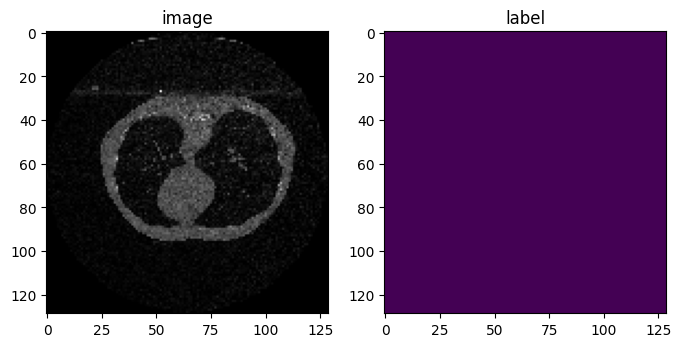

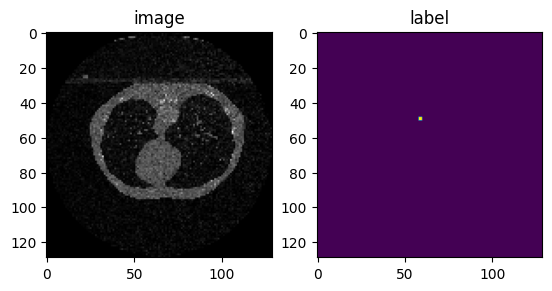

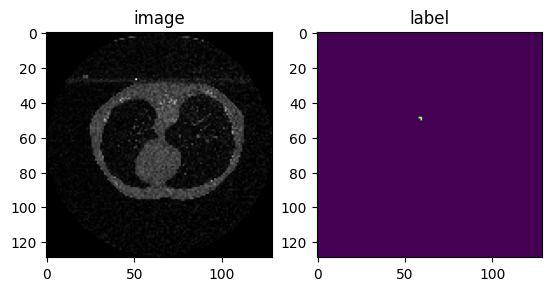

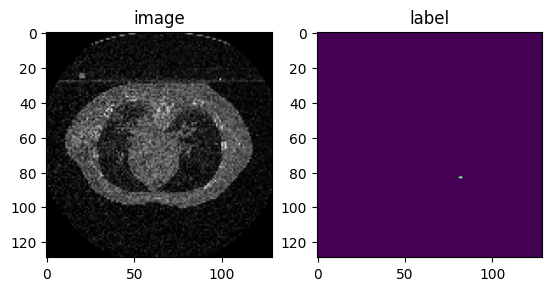

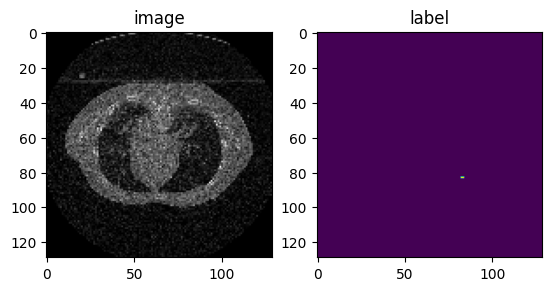

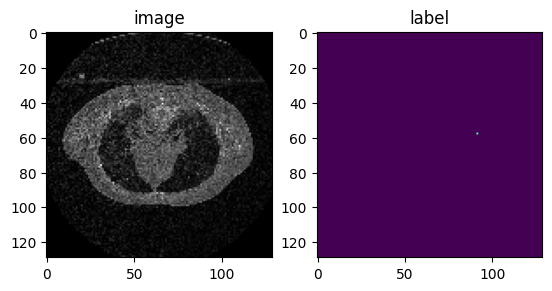

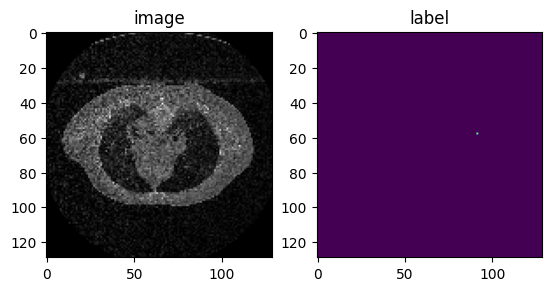

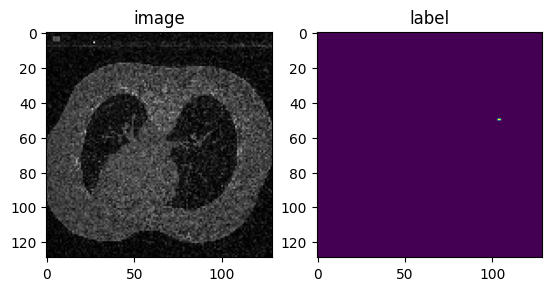

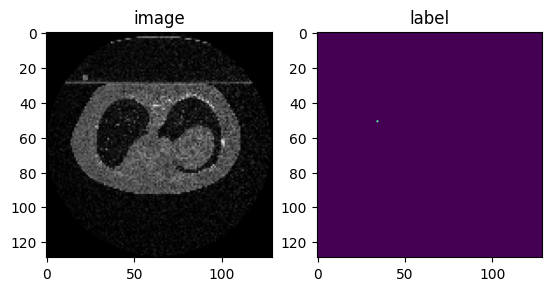

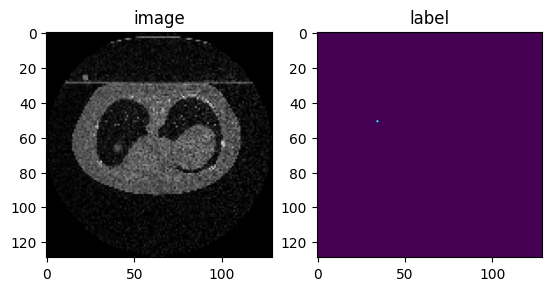

In [165]:
plt.figure("visualize", (8, 4))
for i in range(10):
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(recon_image['image'][0,0,:,:,i], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(recon_image['label'][0,0,:,:,i])
    plt.show()

In [50]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=1,
    img_size=(64,64,64),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)


torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [69]:
loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, softmax = False)

In [76]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [102]:
shutil.copyfile("/kaggle/input/metrics_unetr_checkpoint1/pytorch/checkpoint1/1/best_metric_model.pth", os.path.join("/kaggle/working/", "best_metric_model.pth"))

'/kaggle/working/best_metric_model.pth'

In [77]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  # noqa: B038
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(  # noqa: B038
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/kaggle/working/", "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 10000
eval_num = 500
post_label = AsDiscrete()
post_pred = AsDiscrete(threshold=0.7)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/kaggle/working/", "best_metric_model.pth")))

Training (500 / 10000 Steps) (loss=0.10597):  83%|████████▎ | 15/18 [00:14<00:06,  2.26s/it]

Model Was Saved ! Current Best Avg. Dice: 0.0962725281715393 Current Avg. Dice: 0.0962725281715393


Training (1000 / 10000 Steps) (loss=0.53813):  61%|██████    | 11/18 [00:12<00:16,  2.30s/it]

Model Was Saved ! Current Best Avg. Dice: 0.1466299444437027 Current Avg. Dice: 0.1466299444437027


Training (1500 / 10000 Steps) (loss=0.30249):  39%|███▉      | 7/18 [00:10<00:24,  2.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1466299444437027 Current Avg. Dice: 0.13597768545150757


Training (2000 / 10000 Steps) (loss=0.26629):  17%|█▋        | 3/18 [00:08<00:49,  3.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1466299444437027 Current Avg. Dice: 0.1320076584815979


Training (2500 / 10000 Steps) (loss=0.52130):  94%|█████████▍| 17/18 [00:14<00:02,  2.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1466299444437027 Current Avg. Dice: 0.10852309316396713


Training (3000 / 10000 Steps) (loss=0.08546):  72%|███████▏  | 13/18 [00:12<00:10,  2.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1466299444437027 Current Avg. Dice: 0.13684707880020142


Training (3500 / 10000 Steps) (loss=0.24807):  50%|█████     | 9/18 [00:11<00:19,  2.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1466299444437027 Current Avg. Dice: 0.13456158339977264


Training (4000 / 10000 Steps) (loss=0.41999):  28%|██▊       | 5/18 [00:09<00:32,  2.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1466299444437027 Current Avg. Dice: 0.1356305480003357


Training (4500 / 10000 Steps) (loss=0.46896):   6%|▌         | 1/18 [00:08<02:19,  8.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1466299444437027 Current Avg. Dice: 0.11737648397684097


Training (X / X Steps) (loss=X.X):   0%|          | 0/18 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7c2821cb6ef0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Training (X / X Steps) (loss=X.X):   0%|          | 0/18 [00:06<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 59377, 59378, 59379, 59380, 59381, 59382, 59386) exited unexpectedly

In [52]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")
print(metric_values)

train completed, best_metric: 0.0000 at iteration: 0
[0.0, 0.0]


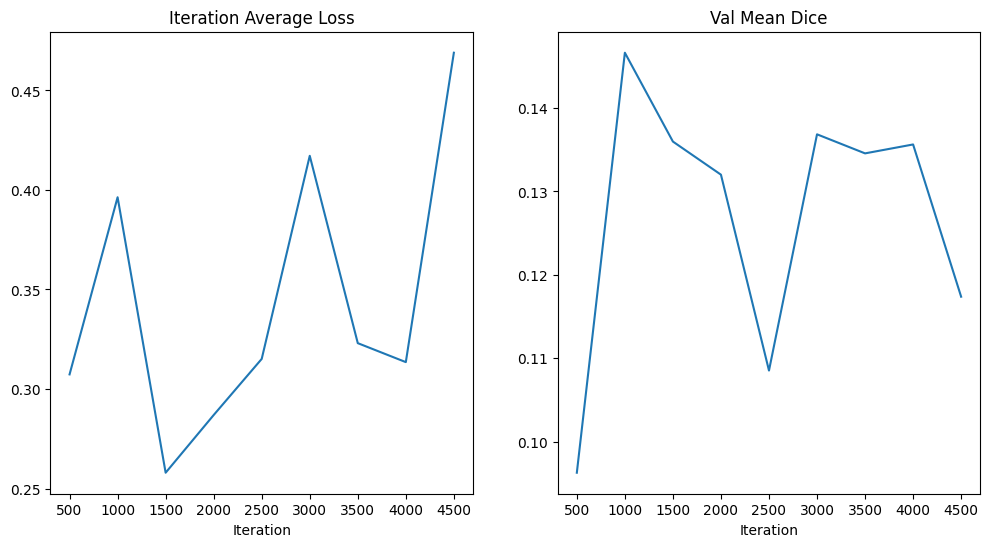

In [78]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

torch.Size([1, 1, 128, 128, 128])


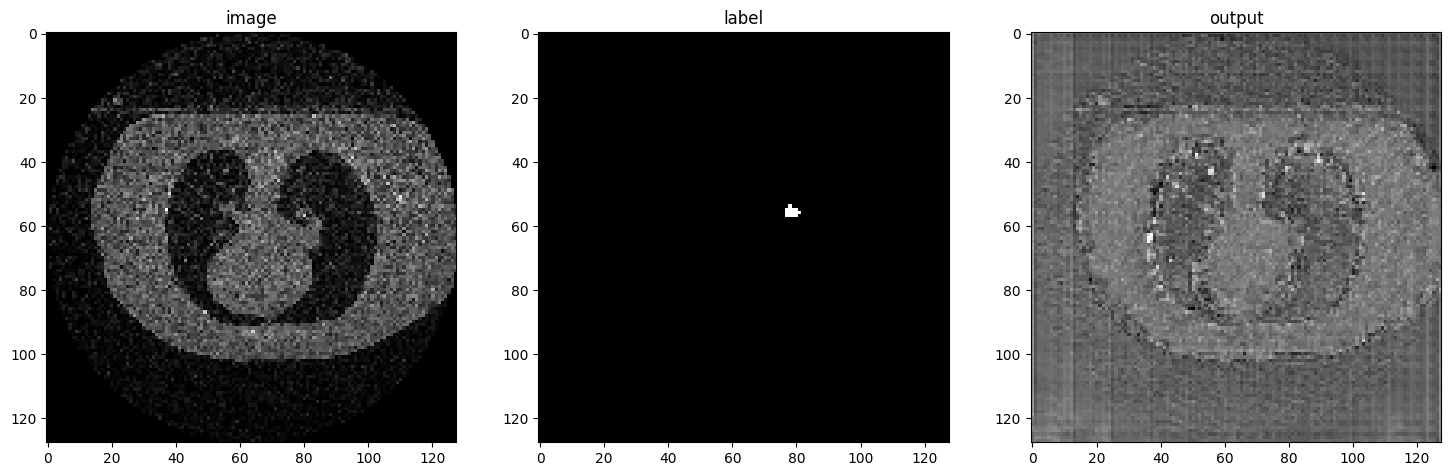

In [79]:

case_num = 4

model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model, overlap=0.8)
    print(val_outputs.shape)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 0], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 0], cmap="gray")
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(val_outputs.cpu().numpy()[0,0,:,:,0], cmap = "gray")
    plt.show()